# TP 5 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

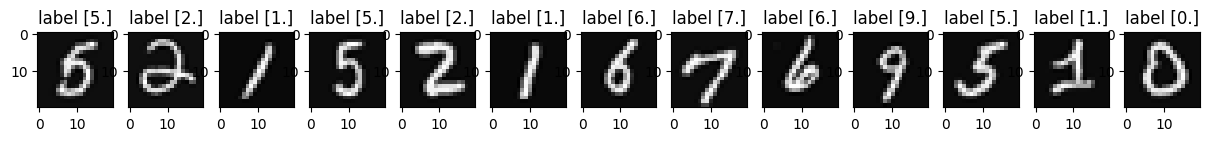

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20)) ##premiere colonne de X est l'intercept
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

transformer les étiquettes de classe y en vecteurs one-hot encoded, ce qui est souvent nécessaire pour les tâches de classification lorsque le modèle de réseau de neurones a une couche de sortie avec plusieurs neurones

In [6]:
# nombre de lignes = nbr d'exemples , nbr de colonnes = plus grand label+1
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [7]:
#cette ligne attribue 1 à la colonne correspondant à la classe de l'exemple dans y
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

C:\Users\taouc\AppData\Local\Temp\ipykernel_10052\972189422.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  YY[i,int(y[i])]=1


Cela revient à la représentation one-hot encoding : une seule valeur est mise à 1 dans le vecteur, correspondant à la classe réelle de l'exemple, tandis que toutes les autres valeurs restent à 0.

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [8]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [9]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [10]:
input_layer_size  = 400
hidden_layer_size = 25   
num_labels = 10

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $



$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \text{Erreur}(x^{(i)}, y^{(i)}, \theta) \right] + \frac{\lambda}{2m} \left[ \text{Régularisation}(\theta^{(1)}) + \text{Régularisation}(\theta^{(2)}) \right] $

Où :

- m est le nombre total d'exemples d'entraînement.
- i est l'indice de l'exemple d'entraînement actuel.
- $ x^{(i)} $ représente les caractéristiques de l'exemple d'entraînement i.
- $ y^{(i)} $ est la classe réelle de l'exemple d'entraînement i.
- θ est l'ensemble des paramètres du modèle.
- λ est le paramètre de régularisation.
- $ \theta^{(1)} $ et $ \theta^{(2)} $ représentent respectivement les poids entre la couche d'entrée et la couche cachée, et entre la couche cachée et la couche de sortie.

La fonction Erreur mesure l'erreur de prédiction pour chaque exemple d'entraînement et est définie comme suit :


$ \text{Erreur}(x^{(i)}, y^{(i)}, \theta) = \sum_{k=1}^K \left[ -y_k^{(i)} \log(h_\theta(x^{(i)}))_k - (1 - y_k^{(i)}) \log(1 - h_\theta(x^{(i)}))_k \right] $


Où :

- K est le nombre total de classes de sortie.
- $ y_k^{(i)} $ est 1 si la classe réelle de l'exemple d'entraînement i est k, et 0 sinon.
- $ h_\theta(x^{(i)}) $ est la prédiction du modèle pour l'exemple d'entraînement i.

La fonction Régularisation mesure la régularisation des poids du modèle et est définie comme suit :

$ \text{Régularisation}(\theta^{(l)}) = \sum_{j=1}^{n_l}\sum_{k=1}^{n_{l-1}} (\theta_{j,k}^{(l)})^2 $

Où :

- n_l est le nombre de neurones dans la couche l du réseau de neurones.
- $ \theta_{j,k}^{(l)} $ est le poids entre le neurone k de la couche (l-1) et le neurone j de la couche l.



In [11]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1 / (1+np.exp(np.clip(-z, -500, 500)))


""" Le np.clip(-z, -500, 500) assure que la valeur de -z reste dans la plage [-500, 500],
 évitant ainsi les problèmes de débordement numérique lorsque z est trop grand ou trop petit.
   Cela garantit que l'exponentielle calculée ne dépasse pas les limites des valeurs numériques représentables """

" Le np.clip(-z, -500, 500) assure que la valeur de -z reste dans la plage [-500, 500],\n évitant ainsi les problèmes de débordement numérique lorsque z est trop grand ou trop petit.\n   Cela garantit que l'exponentielle calculée ne dépasse pas les limites des valeurs numériques représentables "

In [12]:
def computeCost(X: np.ndarray, YY: np.ndarray, *thetas:np.ndarray, lambda_=0):
    m = X.shape[0]
    a1 = X
    theta1, theta2 = thetas
    

    #la couche cachee
    intercept = np.ones((m,1))
    z2 = np.column_stack((intercept, np.matmul(a1, np.transpose(theta1))))
    a2 = Sigmoid(z2)
    a2[:,0] = 1 
    
    #la couche de sortie
    z3 = np.matmul(a2, np.transpose(theta2))
    a3 = Sigmoid(z3)

    reg = (lambda_/(2*m)) * np.sum([np.sum(theta[:,1:]**2) for theta in thetas])
    J = (-np.sum((YY*np.log(a3)) + (1-YY) * np.log(1-a3))) / m + reg

    return J


$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \text{Erreur}(x^{(i)}, y^{(i)}, \theta) \right] + \frac{\lambda}{2m} \left[ \text{Régularisation}(\theta^{(1)}) + \text{Régularisation}(\theta^{(2)}) \right] $

$ \text{Régularisation}(\theta^{(l)}) = \sum_{j=1}^{n_l}\sum_{k=1}^{n_{l-1}} (\theta_{j,k}^{(l)})^2 $

$ \text{Erreur}(x^{(i)}, y^{(i)}, \theta) = \sum_{k=1}^K \left[ -y_k^{(i)} \log(h_\theta(x^{(i)}))_k - (1 - y_k^{(i)}) \log(1 - h_\theta(x^{(i)}))_k \right] $

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [13]:
def compute_activations(X: np.ndarray, *thetas: np.ndarray) -> list[np.ndarray]:
    """     Cette fonction calcule les 
    activations pour chaque couche du reseau
    """    
    activations = []
    a = X

    for theta in thetas:
        a = Sigmoid(np.matmul(a, np.transpose(theta)))
        activations.append(a)
        # ajout d'un biais au activations pour la prochaine couche
        a = np.column_stack((np.ones((a.shape[0],1)), a))
    return activations

In [14]:
def NNCostFunction(X: np.ndarray, YY: np.ndarray, *thetas: list[np.ndarray], lambda_=0):
    m = X.shape[0]
    # calcul des activations pour chaque exemple d'entrainement * une liste de listes 
    activations = compute_activations(X, *thetas)
    Deltas = [np.zeros_like(theta) for theta in thetas] # initialisation des gradients pour chaque couche
    
    for i in range(m):
        #une liste de tableaux où chaque élément de la liste représente les activations de chaque couche pour un seul exemple d'entraînement spécifique
        A = [a[i].reshape(-1,1) for a in activations]
        a_l = A.pop(-1) #extrait l'activation de la couche de sortie de la liste A

        #calcul de l'erreur pour la couche de sortie
        prev_delta = a_l - YY[i].reshape(-1,1)

        # Boucle sur chaque couche cachee en partant de la couche de sortie
        for Delta, theta, a in zip(Deltas[::-1], thetas[::-1], A[::-1]):
            # Ajoute un biais aux activations de chaque couche
            a = np.vstack((np.ones((1, a.shape[1])), a))
            
            Delta += np.matmul(prev_delta, np.transpose(a))
            #Calcule l'erreur (delta) pour la couche actuelle en utilisant la rétropropagation du gradient
            prev_delta = np.matmul(np.transpose(theta), prev_delta) * a * (1-a)

    # Calcul des termes de régularisation pour chaque couche (pour chaque matrice de poids)
    regularizations = [np.hstack((np.zeros((theta.shape[0],1)), theta[:,1:])) for theta in thetas]
    # Calcul des gradients avec régularisation
    grad = [Delta/m + (lambda_/m)*reg for Delta, reg in zip(Deltas, regularizations)]
    J = computeCost(X, YY, *thetas, lambda_=lambda_)

    return J, grad

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [15]:
def gradientDescent(X: np.ndarray, y: np.ndarray, Theta: list[np.ndarray], alpha: float, iterations: int, lambda_=0):
    # Initialise un tableau pour stocker l'historique des coûts pour chaque itération
    J_history = np.zeros((iterations, 1))
    
    # Boucle sur le nombre d'itérations spécifié
    for i in range(iterations):
        # Calcule le coût et les gradients en utilisant la fonction de coût de réseau de neurones
        J, grad = NNCostFunction(X, y, *Theta, lambda_=lambda_)
        
        # Enregistre le coût actuel dans l'historique des coûts
        J_history[i] = J
        
        # Affiche le coût tous les 10 itérations
        if i % 10 == 0:
            print(f'Iteration {i} - Cost {J}')
        
        # Met à jour les paramètres (poids) du réseau en utilisant la descente de gradient
        Theta = [theta - alpha * g for theta, g in zip(Theta, grad)]
    
    # Retourne les paramètres mis à jour et l'historique des coûts
    return Theta, J_history


In [16]:
# Rassemble les poids dans une liste
Theta1 = [W1, W2]


Ce coût total est une mesure de l'erreur globale du modèle pour toutes les classes. Il est calculé en prenant en compte les prédictions du modèle pour toutes les classes et en les comparant aux valeurs réelles

In [17]:
# entrainement
Theta1, J_history = gradientDescent(X, YY, Theta1, 0.7, 121)  #0.5 0.1 0.3 0.7 0.4  # pour le nbr d'iterations 100 suffit

Iteration 0 - Cost 10.441433938769038


Iteration 10 - Cost 7.1201402950392625
Iteration 20 - Cost 4.384267671880341
Iteration 30 - Cost 2.714331055867724
Iteration 40 - Cost 1.9051315488904337
Iteration 50 - Cost 1.485498356253914
Iteration 60 - Cost 1.2430338090439261
Iteration 70 - Cost 1.087858013374782
Iteration 80 - Cost 0.9799633434108926
Iteration 90 - Cost 0.9000961542155177
Iteration 100 - Cost 0.8381407289477022
Iteration 110 - Cost 0.7883443004100443
Iteration 120 - Cost 0.7472105422013605


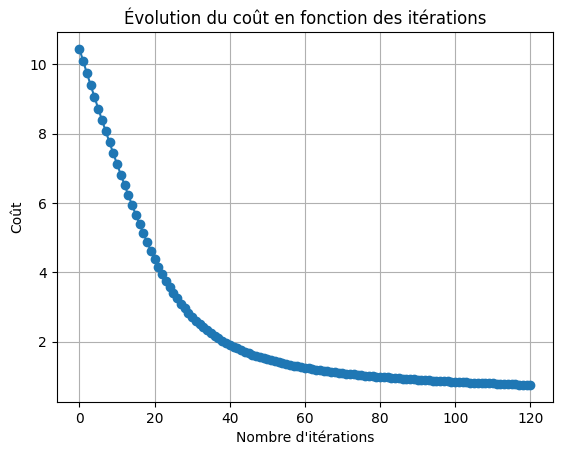

In [18]:
import matplotlib.pyplot as plt

# Création de la figure
plt.figure()

# Tracé du coût en fonction des itérations
plt.plot(range(len(J_history)), J_history, marker='o', linestyle='-')

# Ajout de titres et de labels
plt.title('Évolution du coût en fonction des itérations')
plt.xlabel('Nombre d\'itérations')
plt.ylabel('Coût')

# Affichage de la grille
plt.grid(True)

# Affichage du graphique
plt.show()


# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [30]:
# initialisation des poids
Theta2 = [W1, W2]

* Données d'entraînement appropriées : Si les données d'entraînement sont suffisamment riches et représentatives, le modèle peut déjà généraliser correctement sans nécessiter de régularisation supplémentaire.
* Complexité du modèle : Si le modèle est relativement simple ou si le nombre de paramètres est limité, la régularisation peut ne pas avoir un impact significatif sur sa performance.

In [31]:
Theta2, J_history = gradientDescent(X, YY, Theta2, 0.9, 121, lambda_=0.25)

Iteration 0 - Cost 10.465469065283514
Iteration 10 - Cost 6.278918580079564
Iteration 20 - Cost 3.295867651046883
Iteration 30 - Cost 2.000448153484694
Iteration 40 - Cost 1.45731062069938
Iteration 50 - Cost 1.1853950302079301
Iteration 60 - Cost 1.0252673990928283
Iteration 70 - Cost 0.919054082823337
Iteration 80 - Cost 0.842596971250321
Iteration 90 - Cost 0.784330372819421
Iteration 100 - Cost 0.7380694163001515
Iteration 110 - Cost 0.7002070931649258
Iteration 120 - Cost 0.6684902138133046


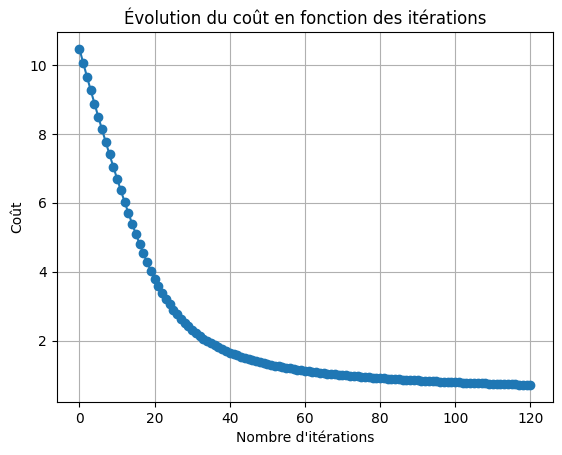

In [21]:
# Création de la figure
plt.figure()

# Tracé du coût en fonction des itérations
plt.plot(range(len(J_history)), J_history, marker='o', linestyle='-')

# Ajout de titres et de labels
plt.title('Évolution du coût en fonction des itérations')
plt.xlabel('Nombre d\'itérations')
plt.ylabel('Coût')

# Affichage de la grille
plt.grid(True)

# Affichage du graphique
plt.show()


# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [32]:
def predict (X, W1, W2):
     # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
    activations = compute_activations(X, W1, W2)
    output = activations[-1]
    y_pred = np.argmax(output, axis=1).reshape(-1, 1)
    return y_pred

In [33]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(X, W1, W2)
precision = np.mean(y==y_pred)*100
precision

0.12

In [24]:
y_pred=predict(X, *Theta1)
precision = np.mean(y==y_pred)*100
precision

91.58

In [34]:
y_pred=predict(X, *Theta2)
precision_reg = np.mean(y==y_pred)*100
precision_reg

92.96

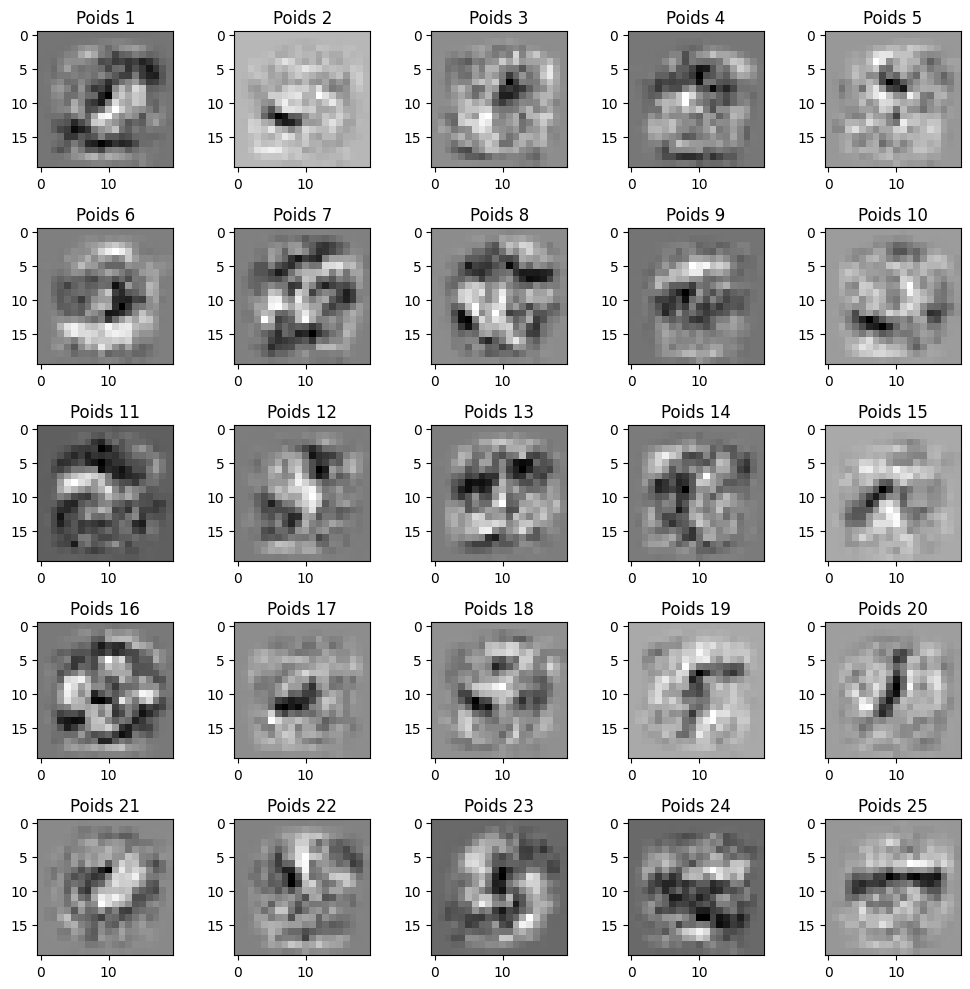

' les "poids 2" représentent les poids associés au deuxième neurone de la couche cachée\n '

In [26]:
# Extraction des poids de la première couche
weights = Theta1[0][:, 1:]  # Ignorer la première colonne correspondant aux biais

# Reshape des poids pour les adapter à une image 20x20
num_images = weights.shape[0]
images_per_row = 5  # Nombre d'images à afficher par ligne
num_rows = (num_images // images_per_row) + (1 if num_images % images_per_row != 0 else 0)

plt.figure(figsize=(images_per_row * 2, num_rows * 2))  # Taille de la figure en pouces

for i in range(num_images):
    plt.subplot(num_rows, images_per_row, i + 1)  # Sélection de la sous-figure actuelle
    plt.imshow(weights[i].reshape(20, 20).T, cmap='gray')  # Affichage de l'image correspondant au poids
    plt.title(f'Poids {i+1}')  # Titre de la sous-figure

plt.tight_layout()  # Ajustement automatique des sous-figures pour éviter les chevauchements
plt.show()  # Affichage de la figure

""" les "poids 2" représentent les poids associés au deuxième neurone de la couche cachée
 """

Ces images montrent comment les entrées sont pondérées et influencent l'activation de chaque neurone dans la couche cachée. 
* Plus les pixels d'une image sont brillants (ou sombres), plus les poids associés à ces pixels ont une influence élevée (ou faible) sur l'activation du neurone correspondant.

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [27]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(hidden_layer_sizes=(25,), activation='logistic', solver='sgd', max_iter=500, batch_size=y.shape[0], learning_rate_init=0.4, alpha=0.4)

In [28]:
nn.fit(X, YY)

C:\Users\taouc\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=0.4, batch_size=5000,
              hidden_layer_sizes=(25,), learning_rate_init=0.4, max_iter=500,
              solver='sgd')

In [29]:
y_pred = nn.predict(X)
y_pred = np.argmax(y_pred, axis=1).reshape(-1)
precision_sk = np.mean(y_pred == y.astype(int).reshape(-1)) * 100
precision_sk

94.06

# Optionnel 2 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

1. Augmentation des données : Créez de nouvelles variations des données en appliquant des transformations.
2. Optimisation des hyperparamètres : Trouvez les meilleurs paramètres pour votre modèle en expérimentant avec différentes valeurs.
3. Utilisation d'algorithmes avancés : Explorez des modèles plus complexes adaptés à vos données, comme les réseaux de neurones convolutionnels ou récurrents.
4. Ensemble Learning : Améliorez les performances en combinant les prédictions de plusieurs modèles.
5. Validation croisée : Évaluez la performance de manière fiable en utilisant la validation croisée.
6. Analyse des erreurs : Comprenez les faiblesses du modèle en analysant les prédictions incorrectes.
7. Réduction de la dimensionnalité : Réduisez le nombre de caractéristiques tout en préservant les informations importantes.
8. Interprétabilité du modèle : Analysez le comportement du modèle pour comprendre ses prédictions.